In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/sugeng/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf

2024-11-12 13:25:00.098081: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 13:25:00.356951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731392700.455232    8911 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731392700.481985    8911 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 13:25:00.736014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the ImageDataGenerator
train_ds = image_dataset_from_directory(
    path+'/dataset/Train',
    validation_split=0.2,
    label_mode='categorical',
    subset="training",
    color_mode='rgb',
    seed=1337,
    image_size=(224, 224),
    shuffle=True,
    batch_size=32,
)
val_ds = image_dataset_from_directory(
    path+'/dataset/Train',
    validation_split=0.2,
    label_mode='categorical',
    subset="validation",
    color_mode='rgb',
    seed=1337,
    shuffle=True,
    image_size=(224, 224),
    batch_size=32,
)

Found 23291 files belonging to 10 classes.
Using 18633 files for training.
Found 23291 files belonging to 10 classes.
Using 4658 files for validation.


In [10]:
'''
Data preprocessing 
- Rescale the pixel values to the [0, 1] range
- Standardize the data
- Enhancing  contrast and brightness
- Higher saturation
- Data augmentation
'''

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomBrightness
# from tensorflow.image import random_saturation
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip

data_augmentation = Sequential([
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomFlip('horizontal'),
])



In [11]:
label = ['freshapples', 'freshbanana', 'freshbittergroud', 'freshcapsicum', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottenbittergroud', 'rottencapsicum', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']
four_class_labels = ['freshapples', 'freshbanana','freshcabbage',  'freshcapsicum',   'freshtomato', 'rottenapples', 'rottenbanana','rottencabbage', 'rottencapsicum',  'rottentomato']

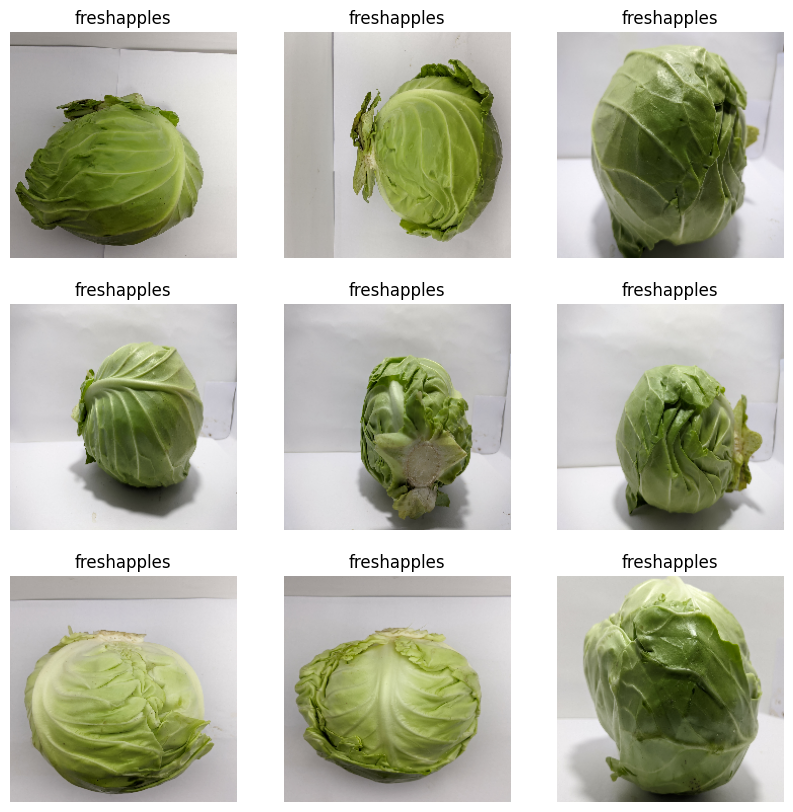

In [12]:
# Plot the first 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(four_class_labels[np.argmax(labels[i])])
        plt.axis("off")
        
plt.show()

2024-11-12 13:26:54.008882: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


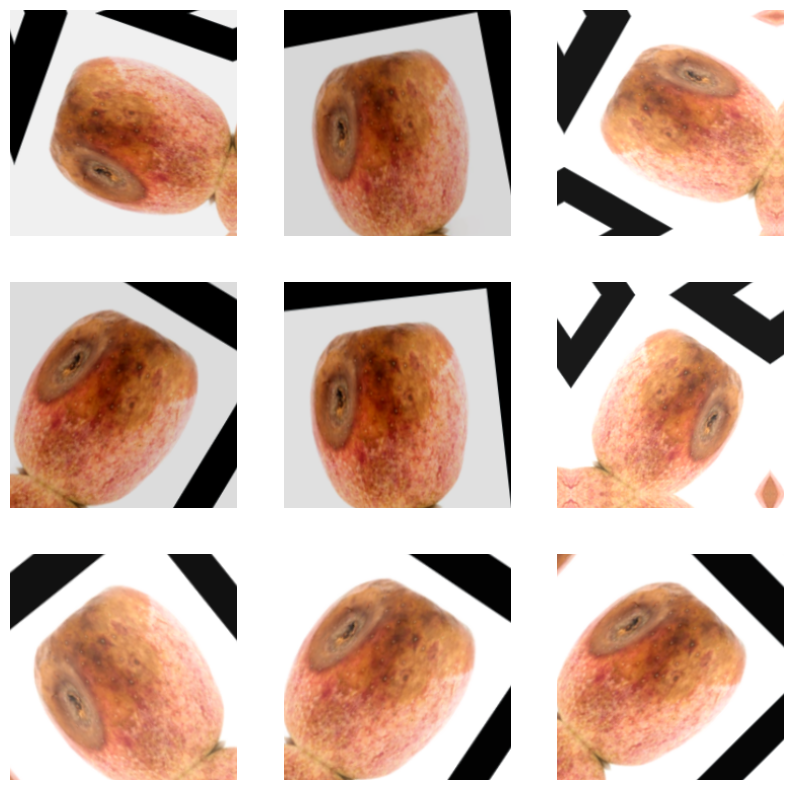

In [8]:
# Plot augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [8]:
# import pretrained model (resnet50)
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetV2L, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Add data augmentation layer
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])




In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stop])


Epoch 1/30


I0000 00:00:1731297544.316689   51588 cuda_dnn.cc:529] Loaded cuDNN version 90300


532/532 ━━━━━━━━━━━━━━━━━━━━ 50s 68ms/step - AUC: 0.9540 - Precision: 0.8246 - Recall: 0.6788 - accuracy: 0.7570 - loss: 0.7575 - val_AUC: 0.9814 - val_Precision: 0.8436 - val_Recall: 0.8077 - val_accuracy: 0.8291 - val_loss: 0.4694
Epoch 2/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - AUC: 0.9918 - Precision: 0.9157 - Recall: 0.8906 - accuracy: 0.9025 - loss: 0.2835 - val_AUC: 0.9967 - val_Precision: 0.9500 - val_Recall: 0.9391 - val_accuracy: 0.9447 - val_loss: 0.1717
Epoch 3/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - AUC: 0.9960 - Precision: 0.9391 - Recall: 0.9265 - accuracy: 0.9328 - loss: 0.1929 - val_AUC: 0.9841 - val_Precision: 0.9070 - val_Recall: 0.8923 - val_accuracy: 0.9010 - val_loss: 0.3849
Epoch 4/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - AUC: 0.9970 - Precision: 0.9474 - Recall: 0.9392 - accuracy: 0.9442 - loss: 0.1582 - val_AUC: 0.9970 - val_Precision: 0.9618 - val_Recall: 0.9591 - val_accuracy: 0.9610 - val_loss: 0.1260
Epoch 5/30
532/532 ━━━━━━━━━━━━━━━━

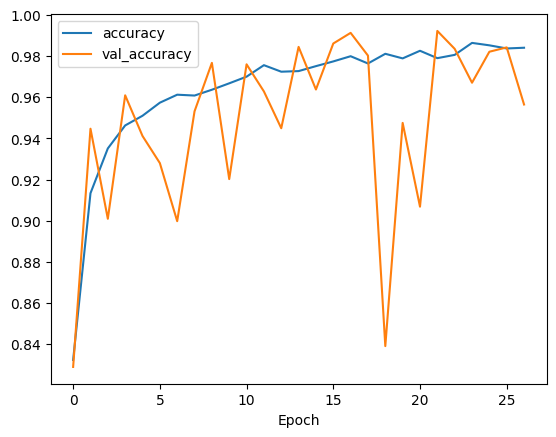

In [15]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

In [16]:
# save model 
import tensorflow as tf
model_without_augmentation = Sequential(model.layers[1:])
model_without_augmentation.save('model.keras')

/home/sugeng/miniconda3/lib/python3.12/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Found 6738 files belonging to 14 classes.
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


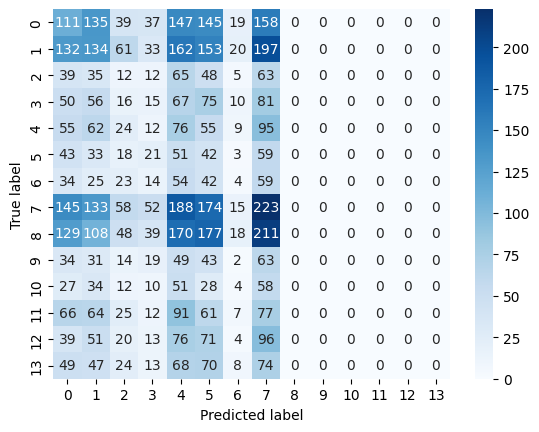

In [12]:
# plot confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn
import pandas

test_ds = image_dataset_from_directory(
    path+'/dataset/Test',
    label_mode='categorical',
    color_mode='rgb',
    seed=1337,
    image_size=(224, 224),
    batch_size=32,
)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred)
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



In [19]:
# pred single image
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/home/sugeng/Downloads/freshtomato.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
for i, lbl in enumerate(four_class_labels):
    print(f'{lbl}: {predictions[0][i]:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
freshapples: 0.0040
freshbanana: 0.0000
freshcapsicum: 0.0002
freshtomato: 0.9958
rottenapples: 0.0000
rottenbanana: 0.0000
rottencapsicum: 0.0000
rottentomato: 0.0000


/home/sugeng/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


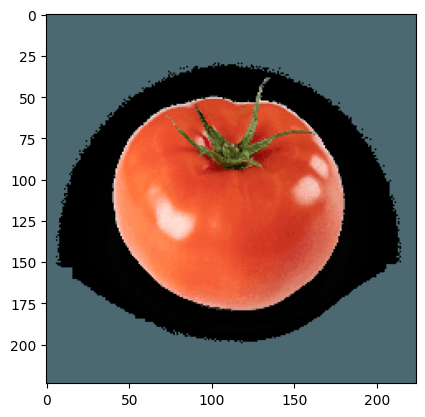

In [20]:
# plot the image
plt.imshow(img)
plt.show()


In [22]:
# reset GPU
from numba import cuda 
device = cuda.get_current_device()
device.reset()